## <center>DataLab Cup 2: CNN for Object Detection</center>

### Dataset

In [1]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

classes_label = [i for i in range(20)]
classes_name_to_label = dict(zip(classes_name, classes_label))

### Processed data format

In [2]:
training_data_file = open("./dataset/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


### Import Package and Check Environment

In [3]:
import tensorflow as tf
import numpy as np
import random
from utils import *
import os
# from data_aug.data_aug import RandomHorizontalFlip, RandomHSV, RandomScale, RandomShear, Sequence
from tqdm import tqdm
import pandas as pd
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import shutil

2023-11-24 00:45:41.680331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


2023-11-24 00:45:43.562937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-24 00:45:43.563092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-24 00:45:43.567399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-24 00:45:43.567529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-24 00:45:43.567676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

#### Hyperparameter

In [5]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './dataset/pascal_voc_training_data.txt'
IMAGE_DIR = './dataset/VOCdevkit_train/VOC2007/JPEGImages/'

DATA_AUG_PATH = './dataset/pascal_voc_training_data_aug.txt'
IMAGE_AUG_DIR = './dataset/VOCdevkit_train/VOC2007/JPEGImages_Aug/'

# stickers params
STICKERS_ROOT_DIR = './bboxs/original_stickers/'

# data augmentation params
CUT_BBOXES = False
DATA_AUG = True

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 50

# sticker params
S_RANGE = [0.2, 2]
BOX_MIN_SIZE = 10
STICKER_COVER_THRES = 0.8

### Data Augmentation

#### Cut Boundiing Boxes and Remove their Background from Original Images

In [6]:
if CUT_BBOXES:
    class_counts, image_name_dict = cut_bboxes(DATA_PATH, IMAGE_DIR, STICKERS_ROOT_DIR)
else:
    class_counts, image_name_dict = count_bboxes(DATA_PATH, IMAGE_DIR)
print(class_counts)
print(image_name_dict)

defaultdict(<class 'int'>, {'chair': 1425, 'car': 1636, 'horse': 403, 'person': 5392, 'bicycle': 417, 'cat': 389, 'dog': 536, 'train': 328, 'aeroplane': 331, 'diningtable': 309, 'tvmonitor': 366, 'bird': 599, 'bottle': 629, 'motorbike': 390, 'pottedplant': 620, 'boat': 398, 'sofa': 419, 'sheep': 353, 'cow': 356, 'bus': 272})
defaultdict(None, {'000005.jpg': array([[263., 211., 324., 339.,   8.],
       [165., 264., 253., 372.,   8.],
       [  5., 244.,  67., 374.,   8.],
       [241., 194., 295., 299.,   8.],
       [277., 186., 312., 220.,   8.]]), '000007.jpg': array([[141.,  50., 500., 330.,   6.]]), '000009.jpg': array([[ 69., 172., 270., 330.,  12.],
       [150., 141., 229., 284.,  14.],
       [285., 201., 327., 331.,  14.],
       [258., 198., 297., 329.,  14.]]), '000012.jpg': array([[156.,  97., 351., 270.,   6.]]), '000016.jpg': array([[ 92.,  72., 305., 473.,   1.]]), '000017.jpg': array([[185.,  62., 279., 199.,  14.],
       [ 90.,  78., 403., 336.,  12.]]), '000019.jpg'

In [7]:
# 排序 class counts
sorted_class_counts = {k: v for k, v in sorted(class_counts.items(), key=lambda item: item[1], reverse=True)}
print(sorted_class_counts)

{'person': 5392, 'car': 1636, 'chair': 1425, 'bottle': 629, 'pottedplant': 620, 'bird': 599, 'dog': 536, 'sofa': 419, 'bicycle': 417, 'horse': 403, 'boat': 398, 'motorbike': 390, 'cat': 389, 'tvmonitor': 366, 'cow': 356, 'sheep': 353, 'aeroplane': 331, 'train': 328, 'diningtable': 309, 'bus': 272}


In [8]:
image_name_list, bboxs_list = zip(*image_name_dict.items())
image_name_list = list(image_name_list)
bboxs_list = list(bboxs_list)

print(image_name_list)
print(bboxs_list)

['000005.jpg', '000007.jpg', '000009.jpg', '000012.jpg', '000016.jpg', '000017.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000023.jpg', '000024.jpg', '000026.jpg', '000030.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000039.jpg', '000041.jpg', '000042.jpg', '000044.jpg', '000046.jpg', '000047.jpg', '000048.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000060.jpg', '000061.jpg', '000063.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000072.jpg', '000073.jpg', '000077.jpg', '000078.jpg', '000081.jpg', '000083.jpg', '000089.jpg', '000091.jpg', '000093.jpg', '000095.jpg', '000099.jpg', '000101.jpg', '000102.jpg', '000104.jpg', '000107.jpg', '000109.jpg', '000110.jpg', '000112.jpg', '000113.jpg', '000117.jpg', '000118.jpg', '000120.jpg', '000121.jpg', '000122.jpg', '000123.jpg', '000125.jpg', '000129.jpg', '000130.jpg', '000131.jpg', '000132.jpg', '000133.jpg', '000134.jpg', '000138.jpg', '000140.jpg', '000141.jpg', '000142.jpg', '000143.jpg', '0001

[array([[263., 211., 324., 339.,   8.],
       [165., 264., 253., 372.,   8.],
       [  5., 244.,  67., 374.,   8.],
       [241., 194., 295., 299.,   8.],
       [277., 186., 312., 220.,   8.]]), array([[141.,  50., 500., 330.,   6.]]), array([[ 69., 172., 270., 330.,  12.],
       [150., 141., 229., 284.,  14.],
       [285., 201., 327., 331.,  14.],
       [258., 198., 297., 329.,  14.]]), array([[156.,  97., 351., 270.,   6.]]), array([[ 92.,  72., 305., 473.,   1.]]), array([[185.,  62., 279., 199.,  14.],
       [ 90.,  78., 403., 336.,  12.]]), array([[231.,  88., 483., 256.,   7.],
       [ 11., 113., 266., 259.,   7.]]), array([[ 33., 148., 371., 416.,   6.]]), array([[  1., 235., 182., 388.,  11.],
       [210.,  36., 336., 482.,  14.],
       [ 46.,  82., 170., 365.,  14.],
       [ 11., 181., 142., 419.,  14.]]), array([[  9., 230., 245., 500.,   1.],
       [230., 220., 334., 500.,   1.],
       [  2., 178.,  90., 500.,   1.],
       [  2.,   1., 117., 369.,  14.],
      

In [9]:
object_num_list = [len(bboxs) for bboxs in bboxs_list]
print(object_num_list)

object_class_list = [[int(bbox[-1]) for bbox in bboxs] for bboxs in bboxs_list]
print(object_class_list)

[5, 1, 4, 1, 1, 2, 2, 1, 4, 6, 1, 1, 3, 4, 3, 2, 4, 1, 1, 3, 2, 2, 1, 2, 2, 10, 3, 6, 5, 2, 2, 1, 1, 3, 2, 4, 2, 2, 9, 6, 4, 3, 2, 2, 1, 2, 2, 3, 3, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 4, 6, 1, 3, 1, 4, 1, 4, 2, 1, 1, 1, 1, 7, 5, 4, 2, 3, 1, 2, 2, 2, 2, 2, 1, 6, 6, 2, 2, 1, 9, 1, 4, 1, 1, 13, 2, 3, 3, 1, 7, 1, 1, 6, 1, 4, 1, 1, 1, 3, 1, 3, 1, 15, 2, 2, 1, 11, 5, 2, 7, 1, 3, 1, 1, 2, 1, 8, 2, 7, 1, 3, 2, 1, 2, 2, 2, 10, 1, 2, 3, 2, 5, 4, 12, 1, 2, 2, 1, 7, 6, 1, 2, 4, 2, 6, 1, 1, 1, 2, 4, 1, 1, 2, 1, 8, 3, 4, 1, 1, 1, 10, 2, 2, 1, 1, 1, 6, 5, 1, 1, 3, 2, 7, 2, 3, 1, 10, 1, 1, 5, 2, 1, 1, 5, 1, 1, 1, 1, 1, 6, 2, 1, 10, 3, 1, 4, 1, 4, 1, 3, 1, 2, 2, 2, 1, 1, 2, 2, 11, 1, 1, 2, 1, 1, 1, 3, 2, 2, 1, 4, 5, 3, 16, 4, 3, 2, 2, 1, 1, 1, 4, 1, 2, 2, 2, 8, 1, 2, 5, 1, 1, 1, 4, 3, 3, 3, 1, 1, 7, 2, 4, 5, 1, 5, 5, 5, 1, 1, 8, 3, 2, 7, 1, 7, 2, 7, 9, 2, 1, 10, 1, 1, 6, 1, 1, 6, 7, 3, 1, 10, 10, 10, 3, 2, 3, 1, 2, 1, 1, 3, 17, 1, 3, 1, 37, 4, 5, 3, 2, 2, 1, 2, 1, 7, 6, 9, 1, 5, 2, 3, 6, 2, 1, 1, 3, 1, 1, 1

#### Data Augmentaation

In [10]:
aug_image_name_list = []
class_count = np.zeros(NUM_CLASSES, int)
total_image_num = len(image_name_list)
image_count = np.zeros(total_image_num, int)

for i in range(total_image_num):
    class_list = object_class_list[i]
    aug_image_name_list.append(f'{image_count[i]}_{image_name_list[i]}')
    image_count[i] += 1
    for c in class_list:
        class_count[c] += 1

LOWER_BOUND = 5000
sorted_indices = np.argsort(object_num_list)[::-1]
invalid_aug = np.zeros(total_image_num, int)
while True:
    for i in sorted_indices:
        class_list = object_class_list[i]
        if invalid_aug[i] or (class_count[class_list] >= LOWER_BOUND).any():
            invalid_aug[i] = 1
            continue
        else:
            aug_image_name_list.append(f'{image_count[i]}_{image_name_list[i]}')
            image_count[i] += 1
            for c in class_list:
                class_count[c] += 1
    if (class_count >= LOWER_BOUND).all():
        break

for r in range(5):
    for c in range(NUM_CLASSES // 5):
        i = r + c * 5
        print(f'{i:2d}) {classes_name[i]:11} {class_count[i]:4d}', end=('\n' if c == 3 else '\t'))

 0) aeroplane   5003	 5) bus         5001	10) diningtable 5000	15) pottedplant 5000
 1) bicycle     5000	 6) car         5002	11) dog         5000	16) sheep       5001
 2) bird        5000	 7) cat         5000	12) horse       5001	17) sofa        5000
 3) boat        5000	 8) chair       5000	13) motorbike   5000	18) train       5000
 4) bottle      5000	 9) cow         5003	14) person      5392	19) tvmonitor   5000


In [11]:
def choose_sticker():
    inverted_class_counts = {key: 1 / value for key, value in class_counts.items()}
    total_count = sum(inverted_class_counts.values())
    probabilities = {key: value / total_count for key, value in inverted_class_counts.items()}
    # sorted_probabilities = {k: v for k, v in sorted(probabilities.items(), key=lambda item: item[1])}
    # print(sorted_probabilities)

    # 透過 class 的出現次數當作機率選擇 class
    choosen_class = random.choices(list(probabilities.keys()), weights=list(probabilities.values()))[0]
    choosen_class_label = classes_name_to_label[choosen_class]
    
    # 隨機選擇 class 內的一張 sticker
    class_dir = os.path.join(STICKERS_ROOT_DIR, choosen_class)
    file_list = os.listdir(class_dir)
    choosen_sticker = random.choice(file_list)
    choosen_sticker_path = os.path.join(class_dir, choosen_sticker)
    return choosen_class_label, choosen_sticker_path

In [12]:
choosen_class_label, chosen_sticker_path = choose_sticker()
print("choosen class label:", choosen_class_label, ", choosen sticker path:", chosen_sticker_path)

choosen class label: 5 , choosen sticker path: ./bboxs/original_stickers/bus/002024_2.jpg


In [13]:
def interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def sticker_cover_rate(dst, src):
    dst_xmin, dst_ymin, dst_xmax, dst_ymax, _ = dst
    src_xmin, src_ymin, src_xmax, src_ymax, _ = src
    
    intersect_w = interval_overlap([dst_xmin, dst_xmax], [src_xmin, src_xmax])
    intersect_h = interval_overlap([dst_ymin, dst_ymax], [src_ymin, src_ymax])
    
    intersect = intersect_w * intersect_h
    sticker_area = (dst_xmax-dst_xmin+1)*(dst_ymax-dst_ymin+1)

    return float(intersect)/sticker_area

In [14]:
def paste_sticker(image, bboxes):    # 在image 隨機選 sticker 貼上
    image_h, image_w, _  = image.shape
    sticker_class_label, sticker_path = choose_sticker()
    sticker = cv2.imread(sticker_path)
    sticker_h, sticker_w, _  = sticker.shape
    scale_max = min(image_h/sticker_h, image_w/sticker_w)
    scale = np.random.uniform(low=max(S_RANGE[0], BOX_MIN_SIZE/min(sticker_h, sticker_w)), high=min(S_RANGE[1], scale_max))
    sticker_h = int(sticker_h * scale)
    sticker_w = int(sticker_w * scale)
    sticker = cv2.resize(sticker, (sticker_w, sticker_h))
    
    if int(image_h - sticker_h) <= 0 or int(image_w - sticker_w) <= 0:
        return image, bboxes
    
    paste_h_offset = random.randint(0, int(image_h - sticker_h))
    paste_w_offset = random.randint(0, int(image_w - sticker_w))
    image[paste_h_offset:paste_h_offset+sticker_h, paste_w_offset:paste_w_offset+sticker_w] = sticker
    # plt.imshow(image)
    # plt.show()
    
    sticker_box = [paste_w_offset, paste_h_offset, paste_w_offset+sticker_w, paste_h_offset+sticker_h, sticker_class_label]
    ret_bboxes = []
    
    for bbox in bboxes:
        if (sticker_cover_rate(bbox, sticker_box) < STICKER_COVER_THRES):
            ret_bboxes.append(bbox)
            
    ret_bboxes.append(sticker_box)  
    ret_bboxes = np.array(ret_bboxes)
    
    # print(bboxes.shape)
    # print(ret_bboxes.shape)
    return image, ret_bboxes
    

In [15]:
def random_horizontal_flip(image, bboxes):
    if random.random() < 0.5:
        _, w, _ = image.shape
        image = image[:, ::-1, :]
        bboxes[:, [0, 2]] = w - bboxes[:, [2, 0]]

    return image, bboxes

In [16]:
def _resize_image(image, bboxes, scale):
    res_image = cv2.resize(image, None,fx=float(scale), fy=float(scale))
    box_shape = bboxes[:, 2:4] - bboxes[:, 0:2]
    bboxes[:, 0:2] = bboxes[:, 0:2] * float(scale)
    bboxes[:, 2:4] = bboxes[:, 0:2] + box_shape * float(scale)
        
    return res_image, bboxes

In [17]:
def random_scale(image, bboxes):
    if random.random() < 0.5:
        h, w, _ = image.shape
        box_wh_min = (bboxes[:, 2:4]-bboxes[:, 0:2]).min()
        scale = np.random.uniform(low=max(S_RANGE[0], BOX_MIN_SIZE/box_wh_min), high=S_RANGE[1])
        image, bboxes = _resize_image(np.copy(image), np.copy(bboxes), scale)
    
    return image, bboxes

In [18]:
def random_crop(image, bboxes):
    if random.random() < 0.5:
        h, w, _ = image.shape
        max_bbox = np.concatenate(
            [
                np.min(bboxes[:, 0:2], axis=0),
                np.max(bboxes[:, 2:4], axis=0),
            ],
            axis=-1,
        )

        max_l_trans = max_bbox[0]
        max_u_trans = max_bbox[1]
        max_r_trans = w - max_bbox[2]
        max_d_trans = h - max_bbox[3]

        crop_xmin = max(
            0, int(max_bbox[0] - random.uniform(0, max_l_trans))
        )
        crop_ymin = max(
            0, int(max_bbox[1] - random.uniform(0, max_u_trans))
        )
        crop_xmax = max(
            w, int(max_bbox[2] + random.uniform(0, max_r_trans))
        )
        crop_ymax = max(
            h, int(max_bbox[3] + random.uniform(0, max_d_trans))
        )

        image = image[crop_ymin:crop_ymax, crop_xmin:crop_xmax]

        bboxes[:, [0, 2]] = bboxes[:, [0, 2]] - crop_xmin
        bboxes[:, [1, 3]] = bboxes[:, [1, 3]] - crop_ymin

    return image, bboxes

In [19]:
def generate_aug_dataset():
    if os.path.exists(IMAGE_AUG_DIR):
        shutil.rmtree(IMAGE_AUG_DIR)

    if not os.path.exists(IMAGE_AUG_DIR):
        os.mkdir(IMAGE_AUG_DIR)

    with open(DATA_AUG_PATH, 'w') as fout:
        np.random.seed(0)
        # seq = Sequence([RandomHSV(50, 50, 50),
        #                 RandomHorizontalFlip(0.5),
        #                 RandomScale(0.15),
        #                 RandomShear(0.15)])
        

        for name in aug_image_name_list:
            name_list = name.split('_')

            img_file = tf.io.read_file(os.path.join(IMAGE_DIR, name_list[1]))
            img = tf.io.decode_jpeg(img_file, channels=3)
            bboxes = image_name_dict.get(name_list[1])

            if name_list[0] != '0':
                # img, bboxes = seq(img.numpy().copy(), bboxes.copy())
                img, bboxes = random_horizontal_flip(np.copy(img), np.copy(bboxes))
                img, bboxes = random_scale(img, bboxes)
                img, bboxes = random_crop(img, bboxes)
                # img, bboxes = paste_sticker(img, bboxes)  # 在augmentation的圖片上面貼貼紙

                # plt.imshow(draw_rect(img, bboxes))
                # plt.show()

            img = tf.io.encode_jpeg(img)
            tf.io.write_file(os.path.join(IMAGE_AUG_DIR, name), img)

            buff_list = [name] + [str(int(b)) for box in bboxes for b in box]
            fout.write(' '.join(buff_list) + '\n')


In [20]:
if DATA_AUG:
    generate_aug_dataset()

### Dataset Loader

We define a class especially to process training data, reading the records from `pascal_voc_training_data.txt` and follow the steps below to prepare data for our network:

1. Create Dataset using tensorflow data API.
2. In Dataset map function, read images and do preprocessing(ex. resizing , normalization).
3. In Dataset map function, change box information [xmin, ymin, xmax, ymax] coordinates into [xcenter, ycenter, width, height] attributes, which is easier for YOLO model to use.
4. Batch, Shuffle operations.

In [21]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts image to densenet input
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_AUG_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1]) // 5, MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] + \
                    [0., 0., 0., 0., 0.] * \
                    (MAX_OBJECTS_PER_IMAGE - len(self.record_list[-1]) // 5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE * 5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE * 5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_AUG_DIR + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.densenet.preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names,
                                                      np.array(self.record_list),
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)\
                         .map(self._data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                         .batch(BATCH_SIZE, drop_remainder=True)\
                         .prefetch(tf.data.experimental.AUTOTUNE)
        return dataset


#### Object Detection Model (YOLO)

Different from Region Proposal based model, YOLO divide an image into cell_size × cell_size (say 7 × 7) cells, each has fixed number of output prediction boxes(coordinates, class_number, and confidence score). The final prediction would be the boxes with highest confidence score. The prediction of YOLO can be based on the output features extracted by the convolutional layers on the input image, which is actually "look once" on each image.

##### Model Architecture

In [22]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same")(inputs)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.BatchNormalization()(x)
    return x


In [23]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# x = tf.keras.applications.densenet.DenseNet121(include_top=False, weights="imagenet")(img_inputs)
x = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet')(img_inputs)
# x = tf.keras.applications.efficientnet_v2.EfficientNetV2S(include_top=False, weights="imagenet")(img_inputs)

# x = conv_leaky_relu(img_inputs, 64, 7, 2)     # inputs, filter數量, filter size, stride
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 192, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 128, 1, 1)
# x = conv_leaky_relu(x, 256, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)

x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")


In [24]:
YOLO.summary()

Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 1024)      18875392  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 1024)      0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 1024)     4096      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 1024)        9438208   
                                                              

### Define Loss

In [25]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])


In [26]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 = tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                       boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    # calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    # calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    # intersection
    intersection = rd - lu

    # the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    # if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    # calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)


def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label :  [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    # Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    # turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)

    # calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    # Step B. calculate the coordination of object center and the corresponding mask
    # turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    # calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1,
                                             center_x, CELL_SIZE - center_x - 1]),
                                   tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    # make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    # Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE,
                                               CELL_SIZE,
                                               BOXES_PER_CELL, 4])
    # cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE,
                                     IMAGE_SIZE / CELL_SIZE,
                                     IMAGE_SIZE, IMAGE_SIZE]

    # if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    # calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    # calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    # replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    # calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    # calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    # calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    # calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    # calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    # class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    # object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    # noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    # coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x) / (IMAGE_SIZE / CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y) / (IMAGE_SIZE / CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w)) / IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h)) / IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss


In [27]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE


#### Start Training

In [28]:
dataset = DatasetGenerator().generate()


In [29]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')


In [30]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)
manager = tf.train.CheckpointManager(ckpt, './ckpts/resnet50v2_0.25_cp', max_to_keep=10, checkpoint_name='yolo')


In [31]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))


In [33]:
from tqdm import tqdm
from datetime import datetime

print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(
        datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))


2023-11-24 00:53:52.300242, start training.


  0%|          | 0/6859 [00:00<?, ?it/s]

2023-11-24 00:53:58.008916: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-11-24 00:53:58.811048: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 00:53:58.872939: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-24 00:53:59.277382: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-24 00:53:59.277436: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance g

2023-11-24 01:05:00.953080, Epoch 1: loss 5.08
Saved checkpoint for epoch 1: ./ckpts/resnet50v2_0.25_cp/yolo-1


100%|██████████| 6859/6859 [11:01<00:00, 10.37it/s]


2023-11-24 01:16:08.915892, Epoch 2: loss 1.98
Saved checkpoint for epoch 2: ./ckpts/resnet50v2_0.25_cp/yolo-2


100%|██████████| 6859/6859 [10:59<00:00, 10.41it/s]


2023-11-24 01:27:09.276353, Epoch 3: loss 1.62
Saved checkpoint for epoch 3: ./ckpts/resnet50v2_0.25_cp/yolo-3


100%|██████████| 6859/6859 [10:55<00:00, 10.46it/s]


2023-11-24 01:38:06.214435, Epoch 4: loss 1.43
Saved checkpoint for epoch 4: ./ckpts/resnet50v2_0.25_cp/yolo-4


100%|██████████| 6859/6859 [10:56<00:00, 10.45it/s]


2023-11-24 01:49:03.561640, Epoch 5: loss 1.30
Saved checkpoint for epoch 5: ./ckpts/resnet50v2_0.25_cp/yolo-5


100%|██████████| 6859/6859 [10:55<00:00, 10.46it/s]


2023-11-24 02:00:00.577363, Epoch 6: loss 1.22
Saved checkpoint for epoch 6: ./ckpts/resnet50v2_0.25_cp/yolo-6


100%|██████████| 6859/6859 [11:00<00:00, 10.39it/s]


2023-11-24 02:11:02.201742, Epoch 7: loss 1.16
Saved checkpoint for epoch 7: ./ckpts/resnet50v2_0.25_cp/yolo-7


100%|██████████| 6859/6859 [11:07<00:00, 10.28it/s]


2023-11-24 02:22:10.642205, Epoch 8: loss 1.10
Saved checkpoint for epoch 8: ./ckpts/resnet50v2_0.25_cp/yolo-8


100%|██████████| 6859/6859 [11:05<00:00, 10.30it/s]


2023-11-24 02:33:17.702528, Epoch 9: loss 1.07
Saved checkpoint for epoch 9: ./ckpts/resnet50v2_0.25_cp/yolo-9


100%|██████████| 6859/6859 [10:56<00:00, 10.45it/s]


2023-11-24 02:44:15.085305, Epoch 10: loss 1.03
Saved checkpoint for epoch 10: ./ckpts/resnet50v2_0.25_cp/yolo-10


100%|██████████| 6859/6859 [10:55<00:00, 10.46it/s]


2023-11-24 02:55:11.930587, Epoch 11: loss 1.01
Saved checkpoint for epoch 11: ./ckpts/resnet50v2_0.25_cp/yolo-11


100%|██████████| 6859/6859 [11:00<00:00, 10.38it/s]


2023-11-24 03:06:13.932222, Epoch 12: loss 0.98
Saved checkpoint for epoch 12: ./ckpts/resnet50v2_0.25_cp/yolo-12


100%|██████████| 6859/6859 [11:01<00:00, 10.38it/s]


2023-11-24 03:17:16.539650, Epoch 13: loss 0.97
Saved checkpoint for epoch 13: ./ckpts/resnet50v2_0.25_cp/yolo-13


100%|██████████| 6859/6859 [11:02<00:00, 10.35it/s]


2023-11-24 03:28:20.469142, Epoch 14: loss 0.94
Saved checkpoint for epoch 14: ./ckpts/resnet50v2_0.25_cp/yolo-14


100%|██████████| 6859/6859 [11:02<00:00, 10.36it/s]


2023-11-24 03:39:23.921947, Epoch 15: loss 0.93
Saved checkpoint for epoch 15: ./ckpts/resnet50v2_0.25_cp/yolo-15


100%|██████████| 6859/6859 [11:02<00:00, 10.36it/s]


2023-11-24 03:50:27.406764, Epoch 16: loss 0.93
Saved checkpoint for epoch 16: ./ckpts/resnet50v2_0.25_cp/yolo-16


100%|██████████| 6859/6859 [11:02<00:00, 10.36it/s]


2023-11-24 04:01:30.994349, Epoch 17: loss 0.91
Saved checkpoint for epoch 17: ./ckpts/resnet50v2_0.25_cp/yolo-17


100%|██████████| 6859/6859 [11:02<00:00, 10.36it/s]


2023-11-24 04:12:34.483029, Epoch 18: loss 0.90
Saved checkpoint for epoch 18: ./ckpts/resnet50v2_0.25_cp/yolo-18


100%|██████████| 6859/6859 [11:01<00:00, 10.36it/s]


2023-11-24 04:23:37.732696, Epoch 19: loss 0.89
Saved checkpoint for epoch 19: ./ckpts/resnet50v2_0.25_cp/yolo-19


100%|██████████| 6859/6859 [11:02<00:00, 10.36it/s]


2023-11-24 04:34:41.359525, Epoch 20: loss 0.89
Saved checkpoint for epoch 20: ./ckpts/resnet50v2_0.25_cp/yolo-20


100%|██████████| 6859/6859 [11:02<00:00, 10.35it/s]


2023-11-24 04:45:45.358570, Epoch 21: loss 0.88
Saved checkpoint for epoch 21: ./ckpts/resnet50v2_0.25_cp/yolo-21


100%|██████████| 6859/6859 [11:02<00:00, 10.36it/s]


2023-11-24 04:56:48.991812, Epoch 22: loss 0.87
Saved checkpoint for epoch 22: ./ckpts/resnet50v2_0.25_cp/yolo-22


100%|██████████| 6859/6859 [11:02<00:00, 10.35it/s]


2023-11-24 05:07:53.053184, Epoch 23: loss 0.87
Saved checkpoint for epoch 23: ./ckpts/resnet50v2_0.25_cp/yolo-23


100%|██████████| 6859/6859 [11:02<00:00, 10.35it/s]


2023-11-24 05:18:57.170481, Epoch 24: loss 0.86
Saved checkpoint for epoch 24: ./ckpts/resnet50v2_0.25_cp/yolo-24


100%|██████████| 6859/6859 [11:02<00:00, 10.35it/s]


2023-11-24 05:30:01.414262, Epoch 25: loss 0.85
Saved checkpoint for epoch 25: ./ckpts/resnet50v2_0.25_cp/yolo-25


100%|██████████| 6859/6859 [11:02<00:00, 10.36it/s]


2023-11-24 05:41:05.141217, Epoch 26: loss 0.85
Saved checkpoint for epoch 26: ./ckpts/resnet50v2_0.25_cp/yolo-26


100%|██████████| 6859/6859 [11:03<00:00, 10.34it/s]


2023-11-24 05:52:09.624830, Epoch 27: loss 0.84
Saved checkpoint for epoch 27: ./ckpts/resnet50v2_0.25_cp/yolo-27


100%|██████████| 6859/6859 [11:02<00:00, 10.35it/s]


2023-11-24 06:03:13.753717, Epoch 28: loss 0.84
Saved checkpoint for epoch 28: ./ckpts/resnet50v2_0.25_cp/yolo-28


100%|██████████| 6859/6859 [11:02<00:00, 10.35it/s]


2023-11-24 06:14:17.770331, Epoch 29: loss 0.84
Saved checkpoint for epoch 29: ./ckpts/resnet50v2_0.25_cp/yolo-29


100%|██████████| 6859/6859 [11:02<00:00, 10.35it/s]


2023-11-24 06:25:21.694369, Epoch 30: loss 0.83
Saved checkpoint for epoch 30: ./ckpts/resnet50v2_0.25_cp/yolo-30


100%|██████████| 6859/6859 [11:02<00:00, 10.35it/s]


2023-11-24 06:36:25.550154, Epoch 31: loss 0.83
Saved checkpoint for epoch 31: ./ckpts/resnet50v2_0.25_cp/yolo-31


100%|██████████| 6859/6859 [11:02<00:00, 10.35it/s]


2023-11-24 06:47:29.393342, Epoch 32: loss 0.82
Saved checkpoint for epoch 32: ./ckpts/resnet50v2_0.25_cp/yolo-32


100%|██████████| 6859/6859 [11:02<00:00, 10.35it/s]


2023-11-24 06:58:33.615565, Epoch 33: loss 0.82
Saved checkpoint for epoch 33: ./ckpts/resnet50v2_0.25_cp/yolo-33


100%|██████████| 6859/6859 [11:03<00:00, 10.34it/s]


2023-11-24 07:09:38.221699, Epoch 34: loss 0.82
Saved checkpoint for epoch 34: ./ckpts/resnet50v2_0.25_cp/yolo-34


100%|██████████| 6859/6859 [11:03<00:00, 10.35it/s]


2023-11-24 07:20:42.626360, Epoch 35: loss 0.82
Saved checkpoint for epoch 35: ./ckpts/resnet50v2_0.25_cp/yolo-35


100%|██████████| 6859/6859 [11:03<00:00, 10.35it/s]


2023-11-24 07:31:47.048902, Epoch 36: loss 0.81
Saved checkpoint for epoch 36: ./ckpts/resnet50v2_0.25_cp/yolo-36


  8%|▊         | 522/6859 [00:50<10:16, 10.29it/s]


KeyboardInterrupt: 

#### Predict Test data

After training, we should run testing on the test data images. Since we should output a txt file in similar format as pascal_voc_training_data.txt, we should change the YOLO output box [xcenter, ycenter, width, height] format back to [xmin, ymin, xmax, ymax].

##### Process YOLO's predictions

In [34]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    # P's shape [7, 7, 2, 20]

    xmin, ymin, xmax, ymax, class_num, conf = [], [], [], [], [], []

    max_conf_idx = np.unravel_index(np.argmax(P), P.shape)
    threshold = P[max_conf_idx] * 0.5

    for i in range(np.prod(P.shape)):
        idx = np.unravel_index(i, P.shape)
        if (P[idx] > threshold):
            class_num.append(idx[3])
            conf.append(P[idx])

            coordinate = np.reshape(coordinate, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))
            xcenter, ycenter, w, h = coordinate[idx[0], idx[1], idx[2], :]

            xcenter = (idx[1] + xcenter) * (IMAGE_SIZE / float(CELL_SIZE))
            ycenter = (idx[0] + ycenter) * (IMAGE_SIZE / float(CELL_SIZE))

            w = w * IMAGE_SIZE
            h = h * IMAGE_SIZE

            xmin.append(xcenter - w / 2.0)
            ymin.append(ycenter - h / 2.0)

            xmax.append(xmin[-1] + w)
            ymax.append(ymin[-1] + h)

    return xmin, ymin, xmax, ymax, class_num, conf


### Build Test dataset Iterator

In [35]:
test_img_dir = './dataset/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []
with open('./dataset/pascal_voc_testing_data.txt', 'r') as fin:
    for line in fin:
        test_images.append(line.strip().split()[0])


def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir + image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.keras.applications.densenet.preprocess_input(image)

    return image_name, image, h, w


test_dataset = tf.data.Dataset.from_tensor_slices(test_images)\
                              .map(load_img_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                              .batch(32)\
                              .prefetch(tf.data.AUTOTUNE)


In [37]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt_path = './ckpts/resnet50v2_0.25_cp/yolo-' + str("34")
print(ckpt_path)
ckpt.restore(ckpt_path)

./ckpts/resnet50v2_0.25_cp/yolo-34


In [38]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)


#### Make Prediction and Output to txt file

To run the evaluation program we provide, you should output your prediction with this format(similar but different with pascal_voc_training_data.txt)

image_name   {xmin_i    ymin_i    xmax_i    ymax_i    class_i    confidence_score} (repeat number of objects times)

In [39]:
output_file = open('./output/test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        # xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        for j in range(len(xmin)):
            xmin[j] = xmin[j] * (img_w[i] / IMAGE_SIZE)
            ymin[j] = ymin[j] * (img_h[i] / IMAGE_SIZE)
            xmax[j] = xmax[j] * (img_w[i] / IMAGE_SIZE)
            ymax[j] = ymax[j] * (img_h[i] / IMAGE_SIZE)
            output_file.write(img_name[i].numpy().decode('ascii')+" %d %d %d %d %d %f\n" % (xmin[j], ymin[j], xmax[j], ymax[j], class_num[j], conf[j]))
        
        # #img filename, xmin, ymin, xmax, ymax, class, confidence
        # output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

#### Run Evaluation Metric

In [40]:
import sys

sys.path.insert(0, './evaluate')

In [41]:
import evaluate
# from evaluate_temp import *

#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./output/test_prediction.txt', './output/output_file.csv')
# evaluate('./output/test_prediction.txt', './output/output_file.csv')

End Evalutation
score: 0.385125


In [46]:
cap = pd.read_csv('./output/efficientnetv2s_0.25_cp/output_file_effcientnetv2s_0.25_cp_3000.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

score: 0.410864


#### Visualization

In [42]:
def random_file_from_directory(directory):
    if not os.path.isdir(directory):
        print(f"Error: '{directory}' is not a directory.")
        return None

    files = os.listdir(directory)
    if not files:
        print(f"No files found in '{directory}'.")
        return None

    random_file_list = []
    for _ in range(5):
        random_file = random.choice(files)
        random_file= os.path.join(directory, random_file)
        random_file_list.append(random_file)
    return random_file_list

folder_path = './dataset/VOCdevkit_test/VOC2007/JPEGImages'

pic0 = [('cat', 0.37500647), ('cat', 0.4877425)]
pic1 = [('sofa', 0.07749454), ('sofa', 0.042642307), ('sofa', 0.039273456), ('sofa', 0.040205147)]
pic2 = [('bird', 0.3350146), ('bird', 0.2540915)]
pic3 = [('dog', 0.3891184), ('dog', 0.40828523)]
pic4 = [('person', 0.098468825), ('person', 0.13507947), ('person', 0.09636544)]


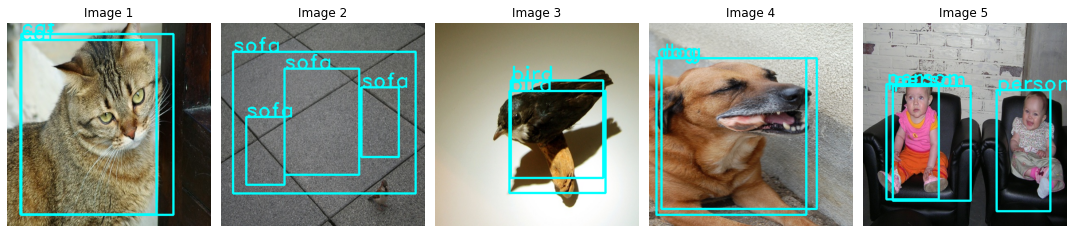

In [43]:
random_selected_file = random_file_from_directory(folder_path)
fig, axs = plt.subplots(1, len(random_selected_file), figsize=(15, 5))

for idx, file_path in enumerate(random_selected_file):
    np_img = cv2.imread(file_path)
    resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    resized_img = np_img
    np_img = np_img.astype(np.float32)
    np_img = np_img / 255.0 * 2 - 1
    np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

    y_pred = YOLO(np_img, training=False)
    xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
    text = []
    for i in range(len(xmin)):
        class_name = classes_name[class_num[i]]
        cv2.rectangle(resized_img, (int(xmin[i]), int(ymin[i])), (int(xmax[i]), int(ymax[i])), (0, 255, 255), 3)
        cv2.putText(resized_img, class_name, (int(xmin[i]), int(ymin[i])), 2, 1.5, (0, 255, 255), 2)
        
        if xmin[i] < 0 or ymin[i] < 0 or xmax[i] < 0 or ymax[i] < 0:
            text_tmp = (class_name, conf[i], xmin[i], ymin[i], xmax[i], ymax[i], conf[i])
            text.append(text_tmp)
        else:
            text_tmp = (class_name, conf[i])
            text.append(text_tmp)
    print(f'pic{idx} = {text}')


    axs[idx].imshow(resized_img)
    axs[idx].set_title(f"Image {idx + 1}")  # Set title for each subplot
    axs[idx].axis('off')  # Hide axes
    
    # plt.imshow(resized_img)
plt.tight_layout()
plt.show()